In [4]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier 
from sklearn.cross_validation import train_test_split
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
%matplotlib inline
files = ['/test.json', '/train.json']
direct = 'C:/Users/danil/Documents/GitHub/Two_Sigma_Connect/Two_Sigma_Connect'

In [10]:
df = pd.read_json(open(direct+files[1],'r'))
df.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street


In [6]:
#Naive feature engineering
df["num_photos"] = df["photos"].apply(len)
df["num_features"] = df["features"].apply(len)
df["num_description_words"] = df["description"].apply(lambda x: len(x.split(" ")))
df["created"] = pd.to_datetime(df["created"])
df["created_year"] = df["created"].dt.year
df["created_month"] = df["created"].dt.month
df["created_day"] = df["created"].dt.day

features_to_use = ["bathrooms", "bedrooms", "latitude", "longitude", "price",
                   "num_photos", "num_features", "num_description_words",
                   "created_year", "created_month", "created_day"]

In [7]:
#Basic encoding of 'manager_id' 
from sklearn import preprocessing

lbl = preprocessing.LabelEncoder()
lbl.fit(list(df['manager_id'].values))
df['manager_id'] = lbl.transform(list(df['manager_id'].values))

# let's add this feature
features_to_use.append('manager_id')

In [8]:
#Split the dataset first to avoid leaking during the validation phase since 
#the columns contain data from the target?
# Let's split the data
X = df[features_to_use]
y = df["interest_level"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)

In [9]:
# compute fractions and count for each manager
temp = pd.concat([X_train.manager_id,pd.get_dummies(y_train)], axis = 1).groupby('manager_id').mean()
temp.columns = ['high_frac','low_frac', 'medium_frac']
temp['count'] = X_train.groupby('manager_id').count().iloc[:,1]

# remember the manager_ids look different because we encoded them in the previous step 
print(temp.tail(10))

            high_frac  low_frac  medium_frac  count
manager_id                                         
3469         0.000000  0.500000     0.500000      2
3470         0.000000  0.000000     1.000000      1
3471         0.000000  1.000000     0.000000      1
3472         0.666667  0.166667     0.166667      6
3473         0.000000  1.000000     0.000000      1
3475         0.200000  0.600000     0.200000      5
3477         0.000000  1.000000     0.000000      4
3478         0.000000  1.000000     0.000000      2
3479         0.200000  0.800000     0.000000      5
3480         0.011765  0.682353     0.305882     85


In [11]:
# compute skill
temp['manager_skill'] = temp['high_frac']*2 + temp['medium_frac']

# get ixes for unranked managers...
unranked_managers_ixes = temp['count']<20
# ... and ranked ones
ranked_managers_ixes = ~unranked_managers_ixes

# compute mean values from ranked managers and assign them to unranked ones
mean_values = temp.loc[ranked_managers_ixes, ['high_frac','low_frac', 'medium_frac','manager_skill']].mean()
print(mean_values)
temp.loc[unranked_managers_ixes,['high_frac','low_frac', 'medium_frac','manager_skill']] = mean_values.values
print(temp.tail(10))

high_frac        0.077414
low_frac         0.671708
medium_frac      0.250879
manager_skill    0.405706
dtype: float64
            high_frac  low_frac  medium_frac  count  manager_skill
manager_id                                                        
3469         0.077414  0.671708     0.250879      2       0.405706
3470         0.077414  0.671708     0.250879      1       0.405706
3471         0.077414  0.671708     0.250879      1       0.405706
3472         0.077414  0.671708     0.250879      6       0.405706
3473         0.077414  0.671708     0.250879      1       0.405706
3475         0.077414  0.671708     0.250879      5       0.405706
3477         0.077414  0.671708     0.250879      4       0.405706
3478         0.077414  0.671708     0.250879      2       0.405706
3479         0.077414  0.671708     0.250879      5       0.405706
3480         0.011765  0.682353     0.305882     85       0.329412


In [12]:
# inner join to assign manager features to the managers in the training dataframe
X_train = X_train.merge(temp.reset_index(),how='left', left_on='manager_id', right_on='manager_id')
X_train.head()

,bathrooms,bedrooms,latitude,longitude,price,num_photos,num_features,num_description_words,created_year,created_month,created_day,manager_id,high_frac,low_frac,medium_frac,count,manager_skill
0,1.0,2,40.8028,-73.9648,3200,5,3,60,2016,4,19,844,0.077414,0.671708,0.250879,15,0.405706
1,1.0,1,40.7207,-73.9801,3485,1,4,23,2016,4,10,381,0.077414,0.671708,0.250879,5,0.405706
2,1.0,1,40.8465,-73.9349,1450,1,0,9,2016,5,25,3135,0.068925,0.683995,0.247079,1712,0.384930
3,2.0,2,40.7053,-74.0161,4850,6,12,163,2016,5,9,3135,0.068925,0.683995,0.247079,1712,0.384930
4,1.0,0,40.7439,-73.9971,2700,4,6,98,2016,4,11,1499,0.006110,0.910387,0.083503,491,0.095723


In [13]:
# add the features computed on the training dataset to the validation dataset
X_val = X_val.merge(temp.reset_index(),how='left', left_on='manager_id', right_on='manager_id')
new_manager_ixes = X_val['high_frac'].isnull()
X_val.loc[new_manager_ixes,['high_frac','low_frac', 'medium_frac','manager_skill']] = mean_values.values
X_val.head()

,bathrooms,bedrooms,latitude,longitude,price,num_photos,num_features,num_description_words,created_year,created_month,created_day,manager_id,high_frac,low_frac,medium_frac,count,manager_skill
0,1.0,2,40.7530,-73.9695,5195,9,5,245,2016,5,16,3128,0.077414,0.671708,0.250879,8.0,0.405706
1,1.0,0,40.7218,-73.8426,1400,0,1,28,2016,4,16,1035,0.077414,0.671708,0.250879,9.0,0.405706
2,2.0,2,40.7269,-73.9876,4450,12,3,40,2016,6,15,2291,0.077414,0.671708,0.250879,NaN,0.405706
3,1.0,2,40.7060,-74.0088,3050,9,18,149,2016,5,2,765,0.040000,0.760000,0.200000,25.0,0.280000
4,1.0,2,40.7514,-73.9862,3300,5,14,130,2016,4,19,3135,0.068925,0.683995,0.247079,1712.0,0.384930


In [14]:
# add manager fractions and skills to the features to use
features_to_use.extend(['high_frac','low_frac', 'medium_frac','manager_skill'])

In [15]:
#Train and validate a few random forest classifiers to see whether we can 
#improve performances with the additional feature

In [16]:
# features to use for this classifier == only basic numerical
these_features = [f for f in features_to_use if f not in ['manager_id','high_frac','low_frac', 'medium_frac','manager_skill']]

clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train[these_features], y_train)
y_val_pred = clf.predict_proba(X_val[these_features])
log_loss(y_val, y_val_pred)

0.63661407366062639

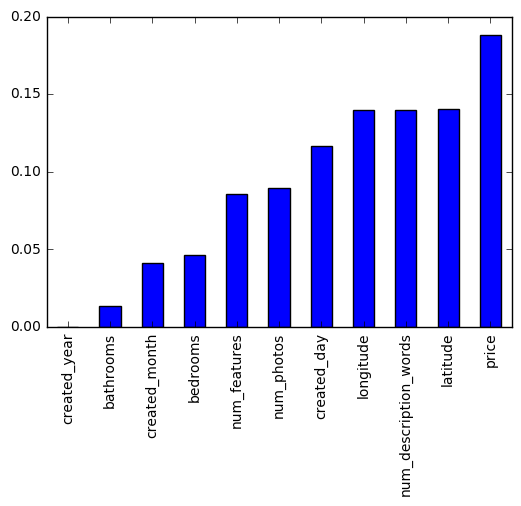

In [17]:
# Let's visualize features importance, 
# price is the most important feature, followed by number of descriptive words, latitude and longitude
pd.Series(index = these_features, data = clf.feature_importances_).sort_values().plot(kind = 'bar')

In [18]:
# add manager_id
these_features = [f for f in features_to_use if f not in ['high_frac','low_frac', 'medium_frac','manager_skill']]

clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train[these_features], y_train)
y_val_pred = clf.predict_proba(X_val[these_features])
log_loss(y_val, y_val_pred)

0.63069183089420622

In [19]:
# no manager_id, use fractions and skill instad
these_features = [f for f in features_to_use if f not in ['manager_id']]

clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train[these_features], y_train)
y_val_pred = clf.predict_proba(X_val[these_features])
log_loss(y_val, y_val_pred)

0.63392896174566571

In [20]:
# no manager_id, no skill, use fractions
these_features = [f for f in features_to_use if f not in ['manager_id','manager_skill']]

clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train[these_features], y_train)
y_val_pred = clf.predict_proba(X_val[these_features])
log_loss(y_val, y_val_pred)

0.62186843670982339

In [21]:
# no manager_id, no fraction, use skill instead
these_features = [f for f in features_to_use if f not in ['manager_id','high_frac','low_frac', 'medium_frac']]

clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train[these_features], y_train)
y_val_pred = clf.predict_proba(X_val[these_features])
log_loss(y_val, y_val_pred)

0.6160838180969288

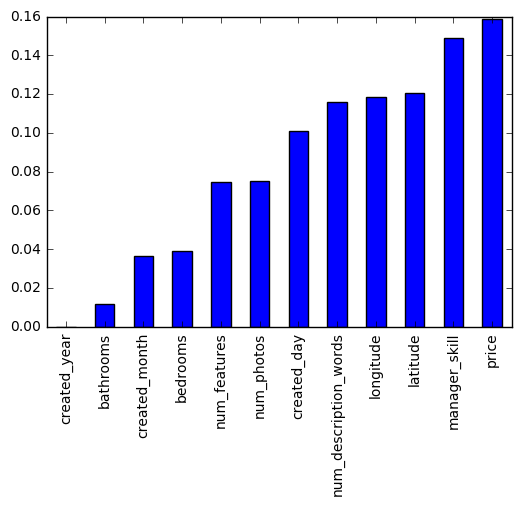

In [22]:
# Let's visualize features importance
pd.Series(index = these_features, data = clf.feature_importances_).sort_values().plot(kind = 'bar')